In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
import time
from contextlib import contextmanager
import torch
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from sklearn.cluster import KMeans
from tqdm import tqdm
# import heapq
from unsloth import FastLanguageModel
from peft import PeftModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


# fin

In [ ]:
dic = {
        0:"negative",
        1:'neutral',
        2:'positive',
    }

def format_example(example: dict) -> dict:
    context = f"Instruction: {example['instruction']}\n"
    if example.get("input"):
        context += f"Input: {example['input']}\n"
    context += "Answer: "
    target = example["output"]
    return {"context": context, "target": target}
    
# instructions = load_dataset("financial_phrasebank", "sentences_50agree")
instructions = load_from_disk("/mnt/bn/data-tns-live-llm/leon/FinGPT/fingpt/FinGPT_Benchmark/data/financial_phrasebank-sentences_50agree/")
instructions = instructions["train"]
instructions = instructions.train_test_split(seed = 42)['test']
instructions = instructions.to_pandas()
instructions.columns = ["input", "output"]
instructions["output"] = instructions["output"].apply(lambda x:dic[x])

instructions["instruction"] = "What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}."

instructions[["context","target"]] = instructions.apply(format_example, axis = 1, result_type="expand")

In [12]:
for i in range(3): print(instructions["context"][i]+" "+instructions["target"][i])

Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}.
Input: L&T has also made a commitment to redeem the remaining shares by the end of 2011 .
Answer:  neutral
Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}.
Input: Copper , lead and nickel also dropped ... HBOS ( HBOS ) plummeted 20 % to 70.3 pence after saying this year+ó ??
Answer:  negative
Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}.
Input: Approximately SEK 166 million in repayments has been demanded for overcharging in the Stockholm area , with the remaining SEK 87 million taken from the Western coast , the inspectorate said .
Answer:  neutral


# 测试

In [2]:
base_data = load_from_disk("/mnt/bn/data-tns-live-llm/leon/datasets/privacy_data/base_med_0.parquet/")
print(base_data["instruction"][:5])
print(len(base_data))

['What are some potential complications of large posterior fibroids?', 'What could be the possible diagnosis for a young patient with a history of ADHD who presents with two weeks of decreased sleep, irritability, distractibility, and excessive involvement in new projects, suggestive of a manic or hypomanic episode?', 'What are the two benefits of a meta-analysis on study findings?', 'What is peripheral vertigo, and what are some possible causes of this condition?', 'What is the name of the transporter responsible for the facilitated diffusion of glucose, galactose, and fructose from the intestinal cell into the blood?']
100


In [ ]:
from vllm import LLM, SamplingParams
llm = LLM(model="/mnt/bn/data-tns-live-llm/leon/datasets/privacy/med_3000_30/checkpoint-700_merged", tensor_parallel_size=1, 
              dtype=torch.bfloat16, trust_remote_code=True, 
              enable_lora=False, max_model_len=2048, gpu_memory_utilization=0.7)

In [4]:
import evaluate
rouge = evaluate.load('rouge')
stop_tokens = ["USER:", "ASSISTANT:",  "### Instruction:", "Response:", 
                "\n\nProblem", "\nProblem", "Problem:", "<|eot_id|>", "####"]
# sampling_params = SamplingParams(temperature=0.5, top_p=1, max_tokens=1024, repetition_penalty=1.1, stop=stop_tokens)
# sampling_params = SamplingParams(temperature=0.1, top_p=1, max_tokens=1024, repetition_penalty=1.1, top_k=1) # when greedy decode, k=1
sampling_params = SamplingParams(top_p=1, max_tokens=1024, repetition_penalty=1.1, top_k=40) # memory extraction

In [ ]:
# model: PeftModelForCausalLM
# tokenizer: LlamaTokenizer
# model, tokenizer = FastLanguageModel.from_pretrained("/mnt/bn/data-tns-live-llm/leon/datasets/privacy/fin_5000",dtype = torch.bfloat16,
#     load_in_4bit = True)
# FastLanguageModel.for_inference(model)
# print("Done")

In [14]:
# from transformers import TextStreamer
# streamer = TextStreamer(tokenizer)
# model.generation_config.pad_token_id = tokenizer.eos_token_id

In [83]:
# def generate_one_completion(instance):
#     inputs = tokenizer(instance, return_tensors="pt")
#     input_ids = inputs.input_ids.to("cuda")
#     attention_mask = inputs.attention_mask.to("cuda")
#     # generate_ids = model.generate(input_ids, max_new_tokens=2048, repetition_penalty=1.1, streamer=streamer, do_sample=True)
#     generate_ids = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=512, repetition_penalty=1.1, streamer=streamer, top_k=40, do_sample=True)
#     outputs = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
#     # print(outputs)
#     return outputs

In [85]:
# generate_one_completion("""Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction:""")
# print("Done")

<|begin_of_text|>Below is an instruction that describes a task. Write a response that appropriately completes the request. Instruction: I will take your book and put it on the table.
Instruction: Please take the ball and throw it to me.
Instruction: Put the box on the shelf.
Instruction:I want you to give me a pencil.<|end_of_text|>
Done


In [ ]:
outputs = llm.generate("""Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:""", sampling_params)
print(outputs[0].outputs[0].text)

In [51]:
template = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
{instruction}

### Response:"""

# 遍历

In [6]:
inputs = [template.format_map({"instruction":input["instruction"]}) for input in base_data] #FedPIT

In [9]:
prefix = """Below is an instruction that describes a task. Write a response that appropriately completes the request.

###Instruction:"""
inputs = [prefix]*1000

In [10]:
outputs = llm.generate(inputs, sampling_params)
response = [output.outputs[0].text for output in outputs]

Processed prompts: 100%|██████████| 1000/1000 [00:40<00:00, 24.92it/s, est. speed input: 548.21 toks/s, output: 2705.18 toks/s]


In [7]:
print(response[:5])

['Write a short essay on what you think are some of the strengths and weaknesses of democracy as a form of government.', "Create an AWS Lambda function in Python using the AWS SDK for Python (Boto3) to delete S3 objects.\n\n###Code:\nimport boto3\ndef lambda_handler(event, context):\n    # Create an S3 client.\n    s3 = boto3.client('s3')\n\n    # Set the bucket name and prefix (optional).\n    bucket_name = 'your-bucket-name'\n    prefix = 'directory/prefix'   # Optional\n\n    # Delete all objects under the specified prefix (if present)\n    if prefix:\n        paginator = s3.get_paginator('list_objects_v2')\n        page_iterator = paginator.paginate(Bucket=bucket_name, Prefix=prefix)\n\n        for page in page_iterator:\n            for obj in page.get('Contents', []):\n                s3.delete_object(Bucket=bucket_name, Key=obj['Key'])\n\n    # Delete all objects in the bucket (including those without a prefix).\n    else:\n        resp = s3.list_objects_v2(Bucket=bucket_name)\n

In [ ]:
# rougeLs = rouge.compute(predictions=response, references=[code_labels]*100)["rougeL"]
rougeLs = rouge.compute(predictions=response, references=[base_data["instruction"]]*1000,rouge_types=['rougeL'],
use_aggregator=False)["rougeL"] # memory extraction
# rougeLs = rouge.compute(predictions=response, references=[base_data["response"]]*100)["rougeL"]
print(rougeLs)

In [9]:
# Unsloth
# rougeLs = []
# for input in tqdm(base_data):
#     response = generate_one_completion(template.format_map({"instruction":input["instruction"]}))
#     rougeLs.append(rouge.compute(predictions=[response.split("Response:")[1]], references=[input["response"]])["rougeL"]) #unsloth
#     rougeLs.append(rouge.compute(predictions=[response], references=[input["response"]])["rougeL"])
# print(sum(rougeLs)/len(base_data))

# 画图

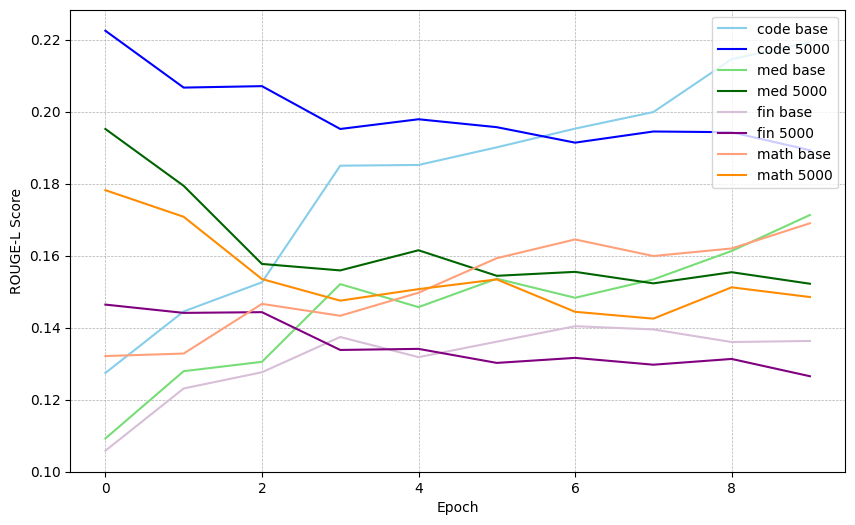

In [1]:
import matplotlib.pyplot as plt
import random

# 数据
epochs = range(0, 10)
code_scores = [0.1274, 0.1445, 0.1526, 0.1850, 0.1852, 0.1901, 0.1953, 0.1999, 0.2146, 0.2193]
code_5000 = [0.2225, 0.2067, 0.2071, 0.1952, 0.1979, 0.1957, 0.1914, 0.1945, 0.1943, 0.1893]
med_scores = [0.1092, 0.1279, 0.1305, 0.1521, 0.1457, 0.1536, 0.1483, 0.1534, 0.1613, 0.1713]
med_5000 = [0.1952, 0.1794, 0.1577, 0.1559, 0.1615, 0.1544, 0.1555, 0.1523, 0.1554, 0.1522]
fin_scores = [0.1058, 0.1231, 0.1276, 0.1374, 0.1318, 0.1361, 0.1404, 0.1395, 0.136, 0.1363]
fin_5000 = [0.1464, 0.1441, 0.1443, 0.1338, 0.1341, 0.1302, 0.1316, 0.1297, 0.1313, 0.1265]
math_scores = [0.1321, 0.1328, 0.1466, 0.1433, 0.1497, 0.1593, 0.1645, 0.1599, 0.162, 0.169]
math_5000 = [0.1782, 0.1708, 0.1535, 0.1475, 0.1507, 0.1534, 0.1444, 0.1425, 0.1512, 0.1485]

# 创建绘图窗口
plt.figure(figsize=(10, 6))

color_groups = [
    ('#87CEEB', '#0000FF'),  # 蓝色组合
    ('#77DD77', '#006400'),  # 绿色组合
    ('#D8BFD8', '#800080'),  # 紫色组合
    ('#FFA07A', '#FF8C00')   # 橙色组合
]

# 绘制曲线
plt.plot(epochs, code_scores, label='code base', color=color_groups[0][0])
plt.plot(epochs, code_5000, label='code 5000', color=color_groups[0][1])
plt.plot(epochs, med_scores, label='med base', color=color_groups[1][0])
plt.plot(epochs, med_5000, label='med 5000', color=color_groups[1][1])
plt.plot(epochs, fin_scores, label='fin base', color=color_groups[2][0])
plt.plot(epochs, fin_5000, label='fin 5000', color=color_groups[2][1])
plt.plot(epochs, math_scores, label='math base', color=color_groups[3][0])
plt.plot(epochs, math_5000, label='math 5000', color=color_groups[3][1])

# 添加标题和标签
plt.xlabel('Epoch')
plt.ylabel('ROUGE-L Score')

# 添加网格
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 设置背景阴影
# plt.gca().set_facecolor('whitesmoke')

# 添加图例
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4)
plt.legend()

# 显示图表
plt.show()
plt.savefig('sine_wave.eps', format='eps')

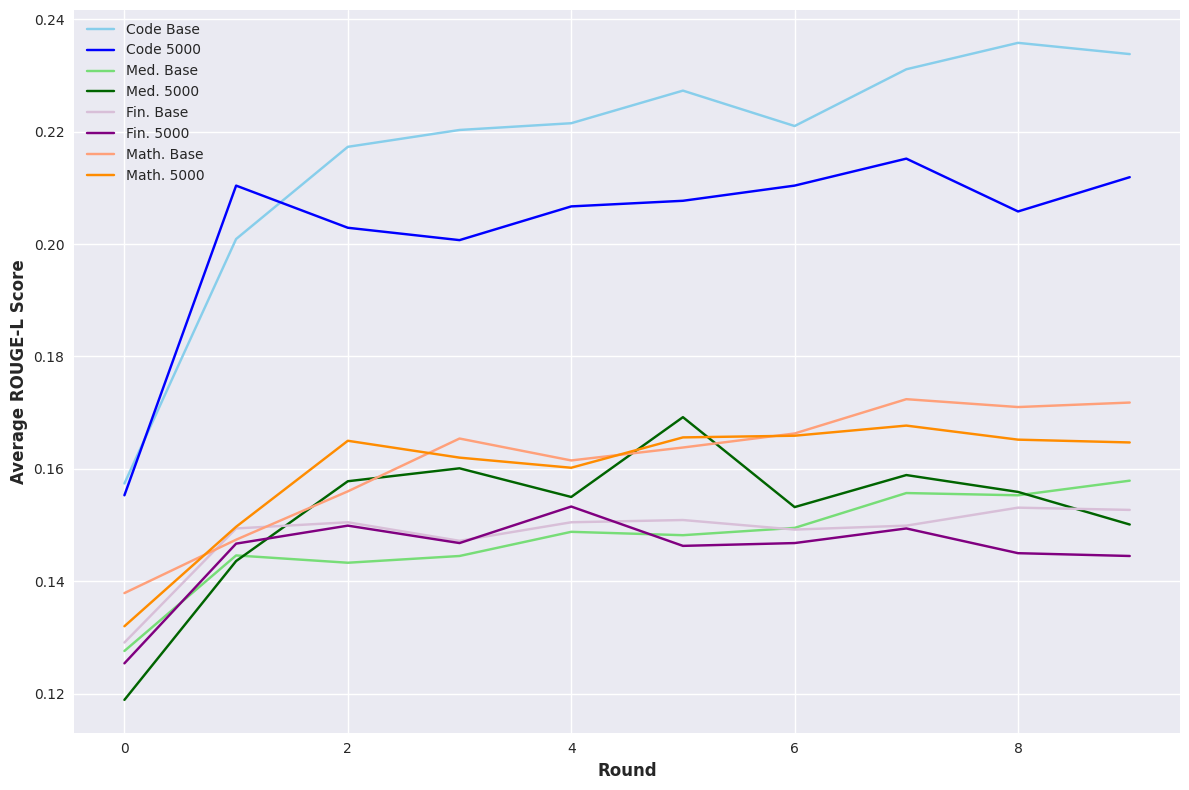

In [3]:
import matplotlib.pyplot as plt
import random

# 数据
epochs = range(0, 10)
code_scores = [0.1574, 0.2009, 0.2173, 0.2203, 0.2215, 0.2273, 0.2210, 0.2311, 0.2358, 0.2338]
code_5000 = [0.1553, 0.2104, 0.2029, 0.2007, 0.2067, 0.2077, 0.2104, 0.2152, 0.2058, 0.2119]
med_scores = [0.1276, 0.1446, 0.1433, 0.1445, 0.1488, 0.1482, 0.1495, 0.1557, 0.1553, 0.1579]
med_5000 = [0.1189, 0.1436, 0.1578, 0.1601, 0.1550, 0.1692, 0.1532, 0.1589, 0.1559, 0.1501]
fin_scores = [0.1291, 0.1494, 0.1505, 0.1472, 0.1505, 0.1509, 0.1492, 0.1499, 0.1531, 0.1527]
fin_5000 = [0.1254, 0.1467, 0.1499, 0.1468, 0.1533, 0.1463, 0.1468, 0.1494, 0.1450, 0.1445]
math_scores = [0.1379, 0.1474, 0.1560, 0.1654, 0.1615, 0.1638, 0.1663, 0.1724, 0.1710, 0.1718]
math_5000 = [0.1320, 0.1497, 0.1650, 0.1620, 0.1602, 0.1656, 0.1659, 0.1677, 0.1652, 0.1647]

# 创建绘图窗口
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 8))

color_groups = [
    ('#87CEEB', '#0000FF'),  # 蓝色组合
    ('#77DD77', '#006400'),  # 绿色组合
    ('#D8BFD8', '#800080'),  # 紫色组合
    ('#FFA07A', '#FF8C00')   # 橙色组合
]

# 绘制曲线
plt.plot(epochs, code_scores, label='Code Base', color=color_groups[0][0])
plt.plot(epochs, code_5000, label='Code 5000', color=color_groups[0][1])
plt.plot(epochs, med_scores, label='Med. Base', color=color_groups[1][0])
plt.plot(epochs, med_5000, label='Med. 5000', color=color_groups[1][1])
plt.plot(epochs, fin_scores, label='Fin. Base', color=color_groups[2][0])
plt.plot(epochs, fin_5000, label='Fin. 5000', color=color_groups[2][1])
plt.plot(epochs, math_scores, label='Math. Base', color=color_groups[3][0])
plt.plot(epochs, math_5000, label='Math. 5000', color=color_groups[3][1])

# 添加标题和标签
plt.xlabel('Round', fontsize=12, fontweight='bold')
plt.ylabel('Average ROUGE-L Score', fontsize=12, fontweight='bold')

# 添加网格
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 设置背景阴影
# plt.gca().set_facecolor('whitesmoke')

# 添加图例
# plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=4)
plt.legend()
plt.tight_layout()
plt.savefig('res/privacy.eps', format='eps')
# 显示图表
plt.show()

In [ ]:
# % \begin{wraptable}{r}{0.6\textwidth}
# % \caption{Privacy-preserving capability against memory extraction attack with different amounts of augmented public data. We report the average ROUGE-L score of each setting in four domains.}
# % \label{tab:privacy}
# % \centering
# % \small
# % \begin{tabular}{c|cccc}
# % \toprule
# % Retrieval Num. & Code & Med. & Fin. & Math. \\
# % \midrule
# % Base Data & 0.2338 & 0.1579 & 0.1527 & 0.1718 \\
# % 1000 & 0.2228 & 0.1505 & 0.1451 & 0.1635 \\
# % 2000 & 0.2226 & 0.1531 & 0.1445 & 0.1627 \\
# % 3000 & 0.2195 & 0.1513 & 0.1454 & 0.1555 \\
# % 4000 & 0.2162 & 0.1434 & 0.1438 & 0.1631 \\
# % 5000 & 0.2119 & 0.1501 & 0.1445 & 0.1647 \\
# % \bottomrule
# % \end{tabular}
# % \vspace{-3mm}
# % \end{wraptable}

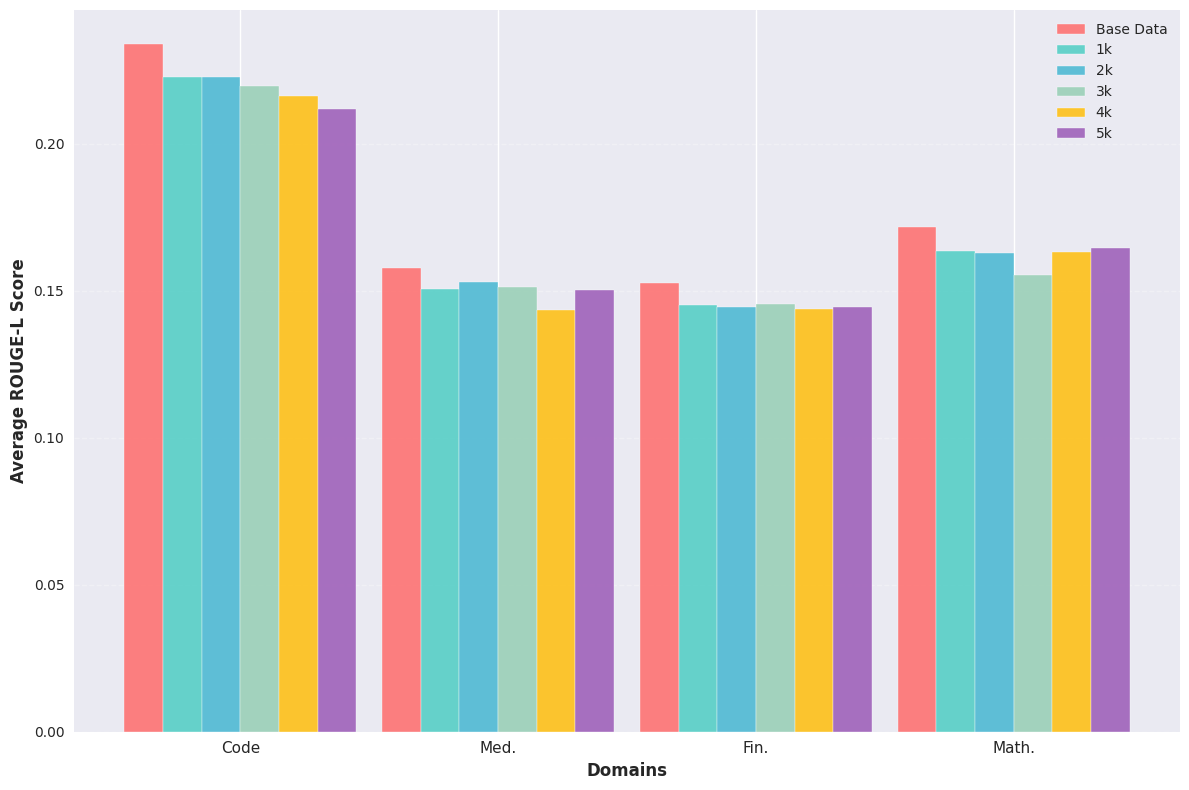

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 设置页面样式
plt.style.use('seaborn-v0_8')
plt.figure(figsize=(12, 8))

# 数据
domains = ['Code', 'Med.', 'Fin.', 'Math.']
base_data = [0.2338, 0.1579, 0.1527, 0.1718]
data_1k = [0.2228, 0.1505, 0.1451, 0.1635]
data_2k = [0.2226, 0.1531, 0.1445, 0.1627]
data_3k = [0.2195, 0.1513, 0.1454, 0.1555]
data_4k = [0.2162, 0.1434, 0.1438, 0.1631]
data_5k = [0.2119, 0.1501, 0.1445, 0.1647]

# 设置柱状图的宽度
bar_width = 0.15

# 设置每个柱子的x轴位置
r1 = np.arange(len(domains))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]
r6 = [x + bar_width for x in r5]

# 使用鲜艳的配色方案
colors = ['#FF6B6B',  # 明亮的红色
          '#4ECDC4',  # 青绿色
          '#45B7D1',  # 天蓝色
          '#96CEB4',  # 薄荷绿
          '#FFBE0B',  # 明黄色
          '#9B59B6']  # 亮紫色

# 创建柱状图
plt.bar(r1, base_data, color=colors[0], width=bar_width, edgecolor='white', label='Base Data', alpha=0.85)
plt.bar(r2, data_1k, color=colors[1], width=bar_width, edgecolor='white', label='1k', alpha=0.85)
plt.bar(r3, data_2k, color=colors[2], width=bar_width, edgecolor='white', label='2k', alpha=0.85)
plt.bar(r4, data_3k, color=colors[3], width=bar_width, edgecolor='white', label='3k', alpha=0.85)
plt.bar(r5, data_4k, color=colors[4], width=bar_width, edgecolor='white', label='4k', alpha=0.85)
plt.bar(r6, data_5k, color=colors[5], width=bar_width, edgecolor='white', label='5k', alpha=0.85)

# 设置网格
plt.grid(True, linestyle='--', alpha=0.3, axis='y')

# 添加标签和标题
plt.xlabel('Domains', fontsize=12, fontweight='bold')
plt.ylabel('Average ROUGE-L Score', fontsize=12, fontweight='bold')
plt.xticks([r + 2.5 * bar_width for r in range(len(domains))], domains, fontsize=11)

# 添加图例
plt.legend()

# 调整布局
plt.tight_layout()

# plt.savefig("privacy_preserving_different_amount.eps", format='eps', dpi=600, bbox_inches='tight')

# 显示图形
plt.show()

# 测试rougeL

In [5]:
import evaluate
rouge = evaluate.load('rouge')
predictions = ["hello goodbye", "ankh morpork"]
references = [["goodbye","world"], ["ankh morpork","general kenobi"]]
results = rouge.compute(predictions=predictions,
references=references,
rouge_types=['rougeL'],
use_aggregator=False)

In [6]:
results

{'rougeL': [0.6666666666666666, 1.0]}

In [7]:
from human_eval.data import write_jsonl, read_problems

problems = read_problems()
print(len(problems.values()))
inputs = [v["prompt"] for v in problems.values()]
print(inputs[:5])

164
['from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n', 'from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n    """ Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n    separate those group into separate strings and return the list of those.\n    Separate groups are balanced (each open brace is properly closed) and not nested within each other\n    Ignore any spaces in the input string.\n    >>> separate_paren_groups(\'( ) (( )) (( )( ))\')\n    [\'()\', \'(())\', \'(()())\']\n    """\n', '\n\ndef truncate_number(number: float) -> float:\n    """ Given a positive floating point number, it c